In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [ ]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [0]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

In [0]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [0]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

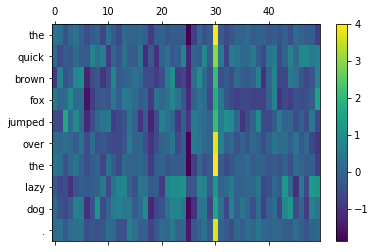

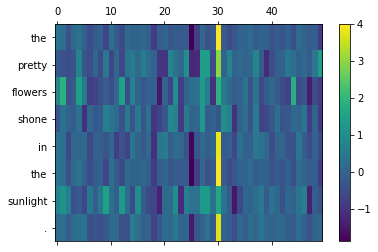

In [0]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [0]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [0]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [0]:
tf.reset_default_graph()


In [0]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [0]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  1%|          | 7/782 [00:02<25:16,  1.96s/it]

Iter 0.0, Minibatch Loss= 1.112793, Training Accuracy= 0.28125


  2%|▏         | 18/782 [00:03<12:19,  1.03it/s]

Iter 10.0, Minibatch Loss= 1.092364, Training Accuracy= 0.39062
Iter 20.0, Minibatch Loss= 1.087251, Training Accuracy= 0.39062


  5%|▍         | 38/782 [00:03<04:15,  2.91it/s]

Iter 30.0, Minibatch Loss= 1.091860, Training Accuracy= 0.36719
Iter 40.0, Minibatch Loss= 1.089727, Training Accuracy= 0.40625


  7%|▋         | 57/782 [00:03<01:34,  7.71it/s]

Iter 50.0, Minibatch Loss= 1.089526, Training Accuracy= 0.45312
Iter 60.0, Minibatch Loss= 1.077253, Training Accuracy= 0.39062


 10%|█         | 81/782 [00:04<00:32, 21.75it/s]

Iter 70.0, Minibatch Loss= 1.085502, Training Accuracy= 0.40625
Iter 80.0, Minibatch Loss= 1.065840, Training Accuracy= 0.42188


 13%|█▎        | 101/782 [00:04<00:18, 36.97it/s]

Iter 90.0, Minibatch Loss= 1.081933, Training Accuracy= 0.43750
Iter 100.0, Minibatch Loss= 1.079775, Training Accuracy= 0.42188


 15%|█▌        | 121/782 [00:04<00:13, 49.35it/s]

Iter 110.0, Minibatch Loss= 1.090609, Training Accuracy= 0.37500
Iter 120.0, Minibatch Loss= 1.076373, Training Accuracy= 0.42969


 18%|█▊        | 142/782 [00:05<00:11, 56.45it/s]

Iter 130.0, Minibatch Loss= 1.074372, Training Accuracy= 0.45312
Iter 140.0, Minibatch Loss= 1.090344, Training Accuracy= 0.38281


 21%|██        | 162/782 [00:05<00:10, 57.99it/s]

Iter 150.0, Minibatch Loss= 1.087760, Training Accuracy= 0.44531
Iter 160.0, Minibatch Loss= 1.065624, Training Accuracy= 0.46875


 23%|██▎       | 176/782 [00:05<00:10, 60.35it/s]

Iter 170.0, Minibatch Loss= 1.084098, Training Accuracy= 0.42969
Iter 180.0, Minibatch Loss= 1.038939, Training Accuracy= 0.42188


 26%|██▌       | 203/782 [00:06<00:09, 58.83it/s]

Iter 190.0, Minibatch Loss= 1.102711, Training Accuracy= 0.34375
Iter 200.0, Minibatch Loss= 1.032724, Training Accuracy= 0.49219


 29%|██▊       | 223/782 [00:06<00:09, 58.72it/s]

Iter 210.0, Minibatch Loss= 1.079500, Training Accuracy= 0.45312
Iter 220.0, Minibatch Loss= 1.050299, Training Accuracy= 0.53906


 30%|███       | 237/782 [00:06<00:09, 59.87it/s]

Iter 230.0, Minibatch Loss= 1.073444, Training Accuracy= 0.46875
Iter 240.0, Minibatch Loss= 1.097890, Training Accuracy= 0.35938


 33%|███▎      | 258/782 [00:07<00:08, 60.50it/s]

Iter 250.0, Minibatch Loss= 1.067177, Training Accuracy= 0.42969
Iter 260.0, Minibatch Loss= 1.085597, Training Accuracy= 0.40625


 36%|███▌      | 279/782 [00:07<00:08, 60.41it/s]

Iter 270.0, Minibatch Loss= 1.056641, Training Accuracy= 0.43750
Iter 280.0, Minibatch Loss= 1.114130, Training Accuracy= 0.41406


 38%|███▊      | 299/782 [00:07<00:07, 61.26it/s]

Iter 290.0, Minibatch Loss= 1.092509, Training Accuracy= 0.38281
Iter 300.0, Minibatch Loss= 1.023688, Training Accuracy= 0.53125


 41%|████      | 320/782 [00:08<00:07, 61.62it/s]

Iter 310.0, Minibatch Loss= 1.069809, Training Accuracy= 0.39844
Iter 320.0, Minibatch Loss= 1.050460, Training Accuracy= 0.46875


 44%|████▎     | 341/782 [00:08<00:07, 58.66it/s]

Iter 330.0, Minibatch Loss= 1.084667, Training Accuracy= 0.39844
Iter 340.0, Minibatch Loss= 1.061602, Training Accuracy= 0.40625


 46%|████▋     | 362/782 [00:08<00:07, 59.78it/s]

Iter 350.0, Minibatch Loss= 1.037640, Training Accuracy= 0.44531
Iter 360.0, Minibatch Loss= 1.053427, Training Accuracy= 0.46875


 49%|████▉     | 383/782 [00:09<00:06, 59.97it/s]

Iter 370.0, Minibatch Loss= 1.076025, Training Accuracy= 0.38281
Iter 380.0, Minibatch Loss= 1.054759, Training Accuracy= 0.44531


 51%|█████     | 397/782 [00:09<00:06, 59.25it/s]

Iter 390.0, Minibatch Loss= 1.061173, Training Accuracy= 0.40625
Iter 400.0, Minibatch Loss= 1.066092, Training Accuracy= 0.43750


 54%|█████▍    | 422/782 [00:09<00:06, 58.55it/s]

Iter 410.0, Minibatch Loss= 1.031103, Training Accuracy= 0.53906
Iter 420.0, Minibatch Loss= 1.042804, Training Accuracy= 0.50000


 57%|█████▋    | 442/782 [00:10<00:05, 58.16it/s]

Iter 430.0, Minibatch Loss= 1.073132, Training Accuracy= 0.42969
Iter 440.0, Minibatch Loss= 1.041043, Training Accuracy= 0.43750


 59%|█████▉    | 461/782 [00:10<00:05, 58.38it/s]

Iter 450.0, Minibatch Loss= 1.098371, Training Accuracy= 0.32812
Iter 460.0, Minibatch Loss= 1.081946, Training Accuracy= 0.48438


 62%|██████▏   | 481/782 [00:10<00:05, 56.31it/s]

Iter 470.0, Minibatch Loss= 1.074165, Training Accuracy= 0.45312
Iter 480.0, Minibatch Loss= 1.081513, Training Accuracy= 0.42188


 64%|██████▍   | 500/782 [00:11<00:04, 59.20it/s]

Iter 490.0, Minibatch Loss= 1.044144, Training Accuracy= 0.50781
Iter 500.0, Minibatch Loss= 1.069568, Training Accuracy= 0.38281


 66%|██████▋   | 519/782 [00:11<00:04, 59.72it/s]

Iter 510.0, Minibatch Loss= 1.020684, Training Accuracy= 0.53906
Iter 520.0, Minibatch Loss= 1.075967, Training Accuracy= 0.46094


 69%|██████▉   | 539/782 [00:11<00:03, 61.62it/s]

Iter 530.0, Minibatch Loss= 1.037971, Training Accuracy= 0.53125
Iter 540.0, Minibatch Loss= 1.014217, Training Accuracy= 0.48438


 72%|███████▏  | 560/782 [00:12<00:03, 62.06it/s]

Iter 550.0, Minibatch Loss= 1.070297, Training Accuracy= 0.43750
Iter 560.0, Minibatch Loss= 1.044470, Training Accuracy= 0.43750


 74%|███████▍  | 581/782 [00:12<00:03, 58.71it/s]

Iter 570.0, Minibatch Loss= 1.017610, Training Accuracy= 0.54688
Iter 580.0, Minibatch Loss= 1.077074, Training Accuracy= 0.39844


 77%|███████▋  | 602/782 [00:12<00:03, 59.80it/s]

Iter 590.0, Minibatch Loss= 1.018385, Training Accuracy= 0.55469
Iter 600.0, Minibatch Loss= 1.033816, Training Accuracy= 0.48438


 80%|███████▉  | 623/782 [00:13<00:02, 59.82it/s]

Iter 610.0, Minibatch Loss= 1.026774, Training Accuracy= 0.44531
Iter 620.0, Minibatch Loss= 1.008996, Training Accuracy= 0.52344


 81%|████████▏ | 637/782 [00:13<00:02, 59.73it/s]

Iter 630.0, Minibatch Loss= 1.057357, Training Accuracy= 0.49219
Iter 640.0, Minibatch Loss= 1.002020, Training Accuracy= 0.49219


 84%|████████▍ | 658/782 [00:13<00:02, 60.75it/s]

Iter 650.0, Minibatch Loss= 1.026549, Training Accuracy= 0.52344
Iter 660.0, Minibatch Loss= 0.999318, Training Accuracy= 0.56250


 87%|████████▋ | 679/782 [00:14<00:01, 60.59it/s]

Iter 670.0, Minibatch Loss= 1.046203, Training Accuracy= 0.50000
Iter 680.0, Minibatch Loss= 1.036910, Training Accuracy= 0.50781


 89%|████████▉ | 699/782 [00:14<00:01, 59.76it/s]

Iter 690.0, Minibatch Loss= 1.045834, Training Accuracy= 0.46875
Iter 700.0, Minibatch Loss= 1.013406, Training Accuracy= 0.51562


 92%|█████████▏| 719/782 [00:14<00:01, 61.22it/s]

Iter 710.0, Minibatch Loss= 0.987604, Training Accuracy= 0.55469
Iter 720.0, Minibatch Loss= 0.977185, Training Accuracy= 0.57031


 95%|█████████▍| 740/782 [00:15<00:00, 62.21it/s]

Iter 730.0, Minibatch Loss= 1.068902, Training Accuracy= 0.43750
Iter 740.0, Minibatch Loss= 1.037516, Training Accuracy= 0.52344


 97%|█████████▋| 761/782 [00:15<00:00, 57.79it/s]

Iter 750.0, Minibatch Loss= 1.028847, Training Accuracy= 0.55469
Iter 760.0, Minibatch Loss= 1.013281, Training Accuracy= 0.56250


100%|██████████| 782/782 [00:16<00:00, 59.34it/s]

Iter 770.0, Minibatch Loss= 1.007033, Training Accuracy= 0.53906
Iter 780.0, Minibatch Loss= 1.026108, Training Accuracy= 0.47656


In [0]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Positive entailment


In [0]:
sess.close()